In [1]:
import numpy as np
import numexpr as ne
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.fft as nfft
%matplotlib inline

from datetime import datetime

from pysquid.rnet import ResistorNetworkModel
from pysquid.model import FluxModelTVPrior
import pysquid.kernels.magpsf as kernel
import pysquid.viz.fit_data_plotting as fdp
import pysquid.util.helpers as hpr

from scipy.io import loadmat,whosmat
from scipy.interpolate import interp2d

import squidimage as sq
reload(sq)


<module 'squidimage' from '/Users/Katja/Dropbox (Nowack lab)/1-Software/Python/CurrentInversionFFT/squidimage.py'>

In [2]:
# Read in the data file and the file containing info about the PSF from vortex imaging
data_dir = os.path.dirname('/Users/Katja/Dropbox (Nowack lab)/1-Software/Matlab/data_hallbar/')
data_file = os.path.join(data_dir,'im_HgTe_Inv_g_n1_061112_0447.mat')
data = loadmat(data_file)

PSF_dir =  os.path.dirname('/Users/Katja/Dropbox (Nowack lab)/1-Software/Matlab/current_inversion/image_kernels/')
PSF_file = os.path.join(PSF_dir,'scan604_kernel.mat')
PSF_all = loadmat(PSF_file)

In [3]:
#data['scans']['forward'][0][0] is a 3D matrix containing mag, current and cap data; [::-1,:,2] selects current 
# and inverts the first direction

#Extract flux_data, size and pixel size
flux_data =  data['scans']['forward'][0][0][: :-1,:,2]
#Extract the pixel size
Ly, Lx = flux_data.shape
flux_range_in_V = data['range'][0]
bendy, bendx = [15.6, 14.5] #bender constants um per V from DAQ
flux_dy, flux_dx = [bendy*flux_range_in_V[1]/Ly, bendx*flux_range_in_V[0]/Lx]

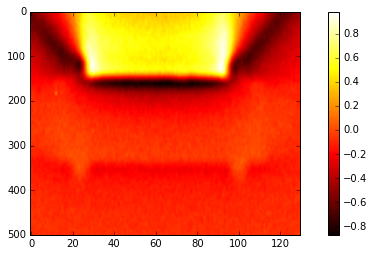

In [4]:
fig, axes = plt.subplots(1,1, figsize=(10,4))
cax= axes.imshow(flux_data,cmap='hot',aspect=flux_dy/flux_dx)
plt.colorbar(cax)

In [5]:
#Create a padded version of the image. Double in size and fading the data to zero towards the new boundaries
flux_data_padded = sq.pad_with_fading(flux_data)
#update Ly and Lx
Ly, Lx = flux_data_padded.shape

In [6]:
#Extract and plot the PSF
PSF_data = PSF_all['kernel_structure']['Kernel'][0][0].real
PSF_data = np.flipud(PSF_data)

PSF_Ly, PSF_Lx = PSF_data.shape
PSF_dx = PSF_all['kernel_structure']['dx'][0][0][0][0]
PSF_dy = PSF_all['kernel_structure']['dy'][0][0][0][0]

In [7]:
#Now pad out the PSF image to the same range (Ly*flux_dy andLx*flux_dx) as the padded flux image 
#but with the grid spacing of the flux data
Ly_pad, Lx_pad = [int(round(Ly*flux_dy/PSF_dy)), int(round(Lx*flux_dx/PSF_dx))]
PSF_data_padded = sq.center_max_on_larger_grid(PSF_data,Lx_pad,Ly_pad)

In [8]:
#Interpolate the flux image on a grid identical to the grid the PSF is defined on
PSF_data_final = sq.interpolate_on_new_grid(PSF_data_padded,Lx,Ly)

In [9]:
#Now we are at a point where we have the PSF data and the flux data loaded in grids of identical size and spacing
# record the final pixel and image size
dx = flux_dx
dy = flux_dy
#potentially change Lx, Ly here to reflect the final size of the image in case you interpolate the image onto 
# grid of the PSF

In [10]:
flux_data_k = nfft.fft2(flux_data_padded)
flux_data_k = nfft.fftshift(flux_data_k)
PSF_data_shift=nfft.fftshift(PSF_data_final)
PSF_k = nfft.fft2(PSF_data_shift)
PSF_k = nfft.fftshift(PSF_k) #*dx*dy

In [11]:
# The next step is to undo the Bio-Savart law and the PSF in Fourier space
# For that need to define the range of the k-vectors, main reason is to make sense of the magnitude of 
# scanheight d 

#Range and step size in k-space
dkx=2*np.pi/(Lx*dx);
dky=2*np.pi/(Ly*dy);
Kx=np.linspace(-np.pi/dx,np.pi/dx-dkx,Lx);
Ky=np.linspace(-np.pi/dy,np.pi/dy-dky,Ly);

In [12]:
print(flux_data_k.shape)
print(PSF_data_final.shape)

(1000, 260)
(1000, 260)


In [14]:
jx_k, jy_k = sq.BiotSavart_k(flux_data_k,PSF_k,Kx,Ky,1.0,1.4,1.2)

jx_k = nfft.fftshift(jx_k)
jy_k = nfft.fftshift(jy_k)
j_x=nfft.ifft2(jx_k)
j_y=nfft.ifft2(jy_k)

# cut out relevant parts of images
j_x_exp = sq.crop(j_x,round(Lx/4),round(Ly/4))

/Users/Katja/Dropbox (Nowack lab)/1-Software/Python/CurrentInversionFFT/squidimage.py:169: RuntimeWarning: invalid value encountered in true_divide
  j_x = -2*1j*kyy*np.exp(K_mat*z)*Bzk*H_mat/(mu_0*K_mat*PSF_k)
/Users/Katja/Dropbox (Nowack lab)/1-Software/Python/CurrentInversionFFT/squidimage.py:170: RuntimeWarning: invalid value encountered in true_divide
  j_y = 2*1j*kxx*np.exp(K_mat*z)*Bzk*H_mat/(mu_0*K_mat*PSF_k)


0.215172413793


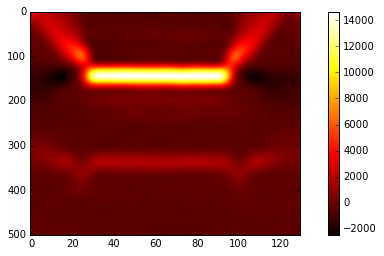

In [16]:
#Some diagnostic plotting. Use nfft,fftshift to move the zero frequency to the center
fig, axes = plt.subplots(1,1, figsize=(10,4))
#cax= axes.imshow(np.subtract(flux_data_inv,flux_data_interp),cmap='hot',aspect=PSF_dy/PSF_dx)
cax= axes.imshow(j_x_exp.real,cmap='hot',aspect=dy/dx)
plt.colorbar(cax)
print(dy/dx)